# Environment Import

In [1]:
import time
import re

import matplotlib.pyplot as plt
import pandas as pd
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.recommendation import ALS
from pyspark.ml.regression import RandomForestRegressor
from pyspark.sql import SparkSession
from pyspark.sql.types import IntegerType
from pyspark.sql import functions as F
from pyspark.sql.functions import col, collect_list, split, explode, avg, udf, expr

# Part 1: Init Spark Session with Ratings

In [2]:
def init_spark_session_with_ratings(filename):
    """
    Reads the ratings file and returns the SparkSession and DataFrame created from the file.

    Args:
    filename (str): The path to the ratings file.

    Returns:
    SparkSession, DataFrame: The Spark session and the DataFrame created from the ratings file.
    """

    # Initialize Spark session
    spark = SparkSession.builder \
        .appName("MovieRecommend") \
        .config("spark.executor.memory", "8g") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.instances", "4") \
        .config("spark.driver.memory", "8G") \
        .getOrCreate()

    ratings_df = spark.read.csv("dataset/ratings.csv", header=True, inferSchema=True)
    print(ratings_df)
    ratings_df.show()

    return spark, ratings_df


spark, ratings_df = init_spark_session_with_ratings("dataset/ratings.csv")

23/11/30 08:05:46 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 192.168.102.123 instead (on interface ens192)
23/11/30 08:05:46 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 08:05:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/11/30 08:05:48 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


DataFrame[userId: int, movieId: int, rating: double, timestamp: int]
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    296|   5.0|1147880044|
|     1|    306|   3.5|1147868817|
|     1|    307|   5.0|1147868828|
|     1|    665|   5.0|1147878820|
|     1|    899|   3.5|1147868510|
|     1|   1088|   4.0|1147868495|
|     1|   1175|   3.5|1147868826|
|     1|   1217|   3.5|1147878326|
|     1|   1237|   5.0|1147868839|
|     1|   1250|   4.0|1147868414|
|     1|   1260|   3.5|1147877857|
|     1|   1653|   4.0|1147868097|
|     1|   2011|   2.5|1147868079|
|     1|   2012|   2.5|1147868068|
|     1|   2068|   2.5|1147869044|
|     1|   2161|   3.5|1147868609|
|     1|   2351|   4.5|1147877957|
|     1|   2573|   4.0|1147878923|
|     1|   2632|   5.0|1147878248|
|     1|   2692|   5.0|1147869100|
+------+-------+------+----------+
only showing top 20 rows



# Part 2: Basic Recommend with Visualization

In [3]:
def basic_recommend(spark, ratings_df):
    """
    Performs basic movie recommendation based on the average rating.

    Args:
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Compute the average rating for each movie
    avg_ratings_df = ratings_df.groupBy("movieId").agg(avg("rating").alias("avg_rating"))

    # Join with the movies DataFrame to get the movie titles and genres
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    joined_df = avg_ratings_df.join(movies_df, "movieId").withColumn("genres", split(col("genres"), "\\|"))

    # Join with the tags DataFrame to get the movie tags, and aggregate tags into a single string for each movie
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)
    joined_df = joined_df.join(tags_df, "movieId").withColumn("tag", col("tag")). \
        groupBy("movieId", "title", "genres", "avg_rating"). \
        agg(expr("concat('[', concat_ws(', ', collect_list(tag)), ']')").alias("tags")
            )

    # Retrieve top 5 movies based on average ratings
    top_movies = joined_df.orderBy(col("avg_rating"), ascending=False).limit(5)
    top_movies.show()

    return top_movies


top_movies = basic_recommend(spark, ratings_df)

+-------+--------------------+--------------------+----------+--------------------+
|movieId|               title|              genres|avg_rating|                tags|
+-------+--------------------+--------------------+----------+--------------------+
| 127080|The Diary of Pres...|    [Drama, Romance]|       5.0|  [independent film]|
| 136988|The Good Mistress...|             [Drama]|       5.0|          [tv movie]|
| 124987|   Snow White (1987)|          [Children]|       5.0|[fairy tale, home...|
| 147615|The Battle of Lov...|[(no genres listed)]|       5.0|[Troma Entertainm...|
| 133307|Time Zero: The La...|       [Documentary]|       5.0|          [business]|
+-------+--------------------+--------------------+----------+--------------------+



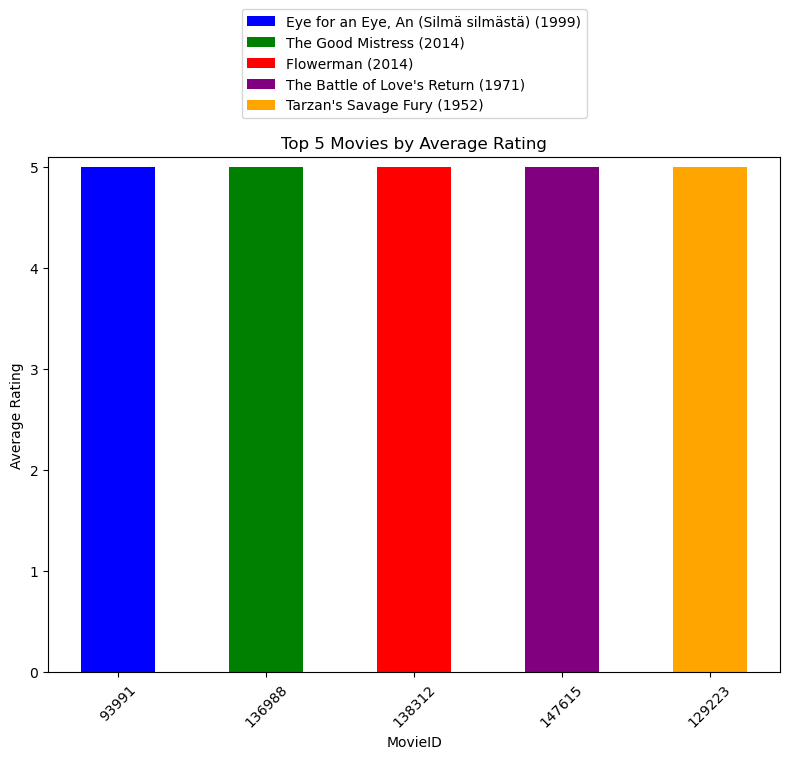

In [4]:
def basic_recommend_visualization(top_movies):
    # Convert Spark DataFrame to Pandas DataFrame for plotting
    top_movies_pd = top_movies.toPandas()

    # Define colors for each movie (you can customize this)
    colors = ['blue', 'green', 'red', 'purple', 'orange']

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(8, 8))

    # Plot each movie as a separate bar
    for i, row in enumerate(top_movies_pd.itertuples(), start=1):
        movie_id = row.movieId
        movie_title = row.title
        avg_rating = row.avg_rating  # Use the column name 'avg_rating'
        color = colors[i - 1]

        # Plot the bar with the movie title as label
        ax.bar(str(movie_id), avg_rating, width=0.5, color=color, label=movie_title)

    # Set labels and title
    ax.set_xlabel('MovieID')
    ax.set_ylabel('Average Rating')
    ax.set_title('Top 5 Movies by Average Rating')

    # Ensure that the top of the bars are within the visible range of the plot
    plt.ylim(0, 5.1)

    # Rotate movie titles for better visibility
    plt.xticks(rotation=45)

    # Add a legend to explain the colors
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3))

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Close the plt object to free memory
    plt.close()


basic_recommend_visualization(top_movies)

# Part3: ALS Recommend with Visualization

## 3.1 Optimal Parameters Chosen

In [5]:
def als_recommend(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares).

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Create an ALS model
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

    # Define a grid of parameters for tuning
    param_grid = {
        "rank": [10, 20],
        "maxIter": [5, 10],
        "regParam": [0.01, 0.1]
    }

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Variables to keep track of the best model and its performance
    best_rmse = float('inf')
    best_error = float('inf')
    best_params = None
    results = []

    # Grid search through the parameter space
    for rank in param_grid["rank"]:
        for max_iter in param_grid["maxIter"]:
            for reg_param in param_grid["regParam"]:
                start_time = time.time()

                # Set model parameters
                als.setParams(rank=rank, maxIter=max_iter, regParam=reg_param)
                
                # Fit ALS model on training data
                model = als.fit(training)
                
                # Evaluate the model on test data
                predictions = model.transform(test)
                rmse = rmse_evaluator.evaluate(predictions)
                mae = mae_evaluator.evaluate(predictions)
                training_time = time.time() - start_time

                # Append results
                results.append({
                    "rank": rank, "maxIter": max_iter, "regParam": reg_param,
                    "RMSE": rmse, "MAE": mae, "Training Time": training_time
                })

                # Update best model
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (rank, max_iter, reg_param)

    # Save the results DataFrame to a CSV file
    results_df = pd.DataFrame(results)
    print(results_df)

    # Display the best model parameters and its RMSE
    print("Best Parameters:", best_params)
    print("Best RMSE:", best_error)


als_recommend(spark, ratings_df)

23/11/30 07:39:37 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


   rank  maxIter  regParam      RMSE       MAE  Training Time
0    10        5      0.01  0.829486  0.638148      47.777165
1    10        5      0.10  0.826285  0.645126      40.870306
2    10       10      0.01  0.810260  0.618900      51.412874
3    10       10      0.10  0.814018  0.631412      49.845394
4    20        5      0.01  0.825468  0.629510      52.075976
5    20        5      0.10  0.829962  0.651692      49.523931
6    20       10      0.01  0.817938  0.620012      67.369276
7    20       10      0.10  0.811837  0.631145      67.318704
Best Parameters: (10, 10, 0.01)
Best RMSE: inf


## 3.2 ALS Recommend With Optimal Parameters

In [6]:
def als_recommend_best(spark, ratings_df):
    """
    Performs movie recommendations using the ALS (Alternating Least Squares) model with optimal parameters.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): The DataFrame containing movie ratings.
    """

    # Split the dataset into training and test sets
    (training, test) = ratings_df.randomSplit([0.7, 0.3])

    # Define multiple evaluators
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Create an ALS model
    als = ALS(rank=10, maxIter=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating", coldStartStrategy="drop")
   
    # Fit ALS model on training data
    model = als.fit(training)

    # Evaluate the model on test data
    predictions = model.transform(test)
    rmse = rmse_evaluator.evaluate(predictions)
    mae = mae_evaluator.evaluate(predictions)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    # Generate top 5 movie recommendations for each user using the best model
    recommendations = model.recommendForAllUsers(5)
    recommendations.show(truncate=False)
    
    return recommendations


recommendations = als_recommend_best(spark, ratings_df)

23/11/30 07:46:42 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.lapack.JNILAPACK


Root Mean Square Error (RMSE): 0.8072171300756796
Mean Absolute Error (MAE): 0.6111281587996001


+------+--------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                         |
+------+--------------------------------------------------------------------------------------------------------+
|31    |[{174403, 6.057178}, {116935, 5.828315}, {126749, 5.7715116}, {136880, 5.447052}, {148859, 5.2071157}]  |
|34    |[{170113, 11.136791}, {112577, 9.995285}, {49872, 9.944384}, {5154, 9.926613}, {133569, 9.79133}]       |
|53    |[{84996, 11.503202}, {198657, 10.026142}, {174403, 9.710598}, {41704, 9.625774}, {167532, 9.444785}]    |
|65    |[{147354, 15.017892}, {134117, 14.216842}, {149130, 13.8547}, {176999, 13.626796}, {26611, 13.5799885}] |
|78    |[{26968, 10.760106}, {162006, 9.259368}, {112577, 9.147092}, {119754, 8.7132635}, {147236, 8.678355}]   |
|85    |[{135585, 11.549908}, {125938, 11.525369}, {183875, 11.525028}, {133325, 10.7987

In [7]:
def als_recommend_visualization(recommendations):
    recs_exploded = recommendations.withColumn("rec_exp", explode("recommendations")).select("userId", col("rec_exp.movieId"), col("rec_exp.rating"))
    recs_exploded.show()
    
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)
    recs_joined = recs_exploded.join(movies_df, "movieId").select("userId", "title", "rating")
    recs_pd = recs_joined.toPandas()

    # # Count the number of recommendations for each movie and get the top 5
    # top_movies = recs_pd['title'].value_counts().head(5)

    # # Plotting the number of times each movie is recommended using the movie titles
    # plt.figure(figsize=(12, 8))
    # top_movies.plot(kind='bar')
    # plt.xlabel('Movie Title')  # Changed from 'Movie ID' to 'Movie Title'
    # plt.ylabel('Number of Recommendations')
    # plt.title('Top 5 Recommended Movies by ALS Model')
    # plt.xticks(rotation=45, ha='right')  # Rotate the x-axis labels for better readability
    # plt.tight_layout()  # Adjust the layout to fit the labels
    # plt.show()
    # plt.close()
     

als_recommend_visualization(recommendations)

+------+-------+----------+
|userId|movieId|    rating|
+------+-------+----------+
|    31| 174403|  6.057178|
|    31| 116935|  5.828315|
|    31| 126749| 5.7715116|
|    31| 136880|  5.447052|
|    31| 148859| 5.2071157|
|    34| 170113| 11.136791|
|    34| 112577|  9.995285|
|    34|  49872|  9.944384|
|    34|   5154|  9.926613|
|    34| 133569|   9.79133|
|    53|  84996| 11.503202|
|    53| 198657| 10.026142|
|    53| 174403|  9.710598|
|    53|  41704|  9.625774|
|    53| 167532|  9.444785|
|    65| 147354| 15.017892|
|    65| 134117| 14.216842|
|    65| 149130|   13.8547|
|    65| 176999| 13.626796|
|    65|  26611|13.5799885|
+------+-------+----------+
only showing top 20 rows



# Part 4: RF Recommend with Visualization

In [3]:
def feature_engineering(spark, ratings_df):
    """
    Perform feature engineering for movie recommendations. This includes processing movie genres and tags,
    and applying one-hot encoding.

    Args:
    spark (SparkSession): SparkSession object for DataFrame operations.
    ratings_df (DataFrame): DataFrame containing movie ratings.

    Returns:
    DataFrame: A DataFrame with combined movie features ready for model training.
    """

    # Converts a list of vectors into a single vector by summing up each dimension.
    def sum_vectors(vectors):
        return Vectors.dense(sum(v[0] for v in vectors))

    sum_vectors_udf = udf(sum_vectors, VectorUDT())

    # Load and preprocess datasets
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)    # movieId, title, genres
    tags_df = spark.read.csv("dataset/tags.csv", header=True, inferSchema=True)    # userId, movieId, tag, timestamp
    print("Initial Movies DataFrame:", movies_df.take(5))
    print("Initial Tags DataFrame:", tags_df.take(5))

    # Process genres: split, explode, and one-hot encode
    movies_df = movies_df.withColumn("split_genres", split(col("genres"), "\|"))    # Split genres into individual genres
    movies_exploded = movies_df.withColumn("genre", explode(col("split_genres")))   # Explode genres into new rows
    genre_indexer = StringIndexer(inputCol="genre", outputCol="genreIndex")
    indexed_genre = genre_indexer.fit(movies_exploded).transform(movies_exploded)
    genre_encoder = OneHotEncoder(inputCol="genreIndex", outputCol="genreVec")
    encoded_genre = genre_encoder.fit(indexed_genre).transform(indexed_genre)
    print("Movies DataFrame after splitting genres:", movies_df.take(5))
    print("Movies DataFrame after splitting and exploding genres:", movies_exploded.take(5))
    print("Indexed Genre DataFrame:", indexed_genre.take(5))
    print("Encoded Genre DataFrame:", encoded_genre.take(5))

    # Aggregate the encoded genres back to movie level
    genre_aggregated = encoded_genre.groupBy("movieId").agg(collect_list("genreVec").alias("genreVecList"))
    genre_aggregated = genre_aggregated.withColumn("genresVec", sum_vectors_udf("genreVecList"))
    print("Aggregated Genre DataFrame:", genre_aggregated.take(5))

    # Process tags using StringIndexer + OneHotEncoder
    tag_indexer = StringIndexer(inputCol="tag", outputCol="tagIndex")
    tag_model = tag_indexer.fit(tags_df)
    indexed_tags = tag_model.transform(tags_df)
    tag_encoder = OneHotEncoder(inputCols=["tagIndex"], outputCols=["tagVec"])
    tags_encoded = tag_encoder.fit(indexed_tags).transform(indexed_tags)
    print("Indexed Tags DataFrame:", indexed_tags.take(5))
    print("Encoded Tags DataFrame:", tags_encoded.take(5))

    def parse_year(title):
        pattern = r"\((\d{4})\)"  # Regular expression pattern to extract the year
        match = re.search(pattern, title)
        if match:
            year_str = match.group(1)
            return int(year_str)
        else:
            return 1900
    
    # Extract movie year
    parse_year_udf = udf(parse_year, IntegerType())
    joined_df = ratings_df.join(movies_df, "movieId")

    # Add the 'movie_year' column
    joined_df = joined_df.withColumn("movie_year", parse_year_udf(joined_df['title']))

    # Explode tag vectors into a list of features for each movie
    movie_tags_features = tags_encoded.groupBy('movieId').agg(F.collect_list('tagVec').alias('tagVectors'))
    movie_tags_features = movie_tags_features.withColumn('tagFeatures', sum_vectors_udf('tagVectors')).drop('tagVectors')
    print("Movie Tags Features DataFrame:", movie_tags_features.take(5))

    # Combine movie features with ratings
    complete_data_df = joined_df.join(genre_aggregated.select("movieId", "genresVec"), "movieId").join(movie_tags_features, "movieId")
    print("Complete Data DataFrame after combining features with ratings:", complete_data_df.take(5))

    # Create feature vectors
    assembler = VectorAssembler(
    inputCols=["userId", "movieId", "timestamp", "movie_year"] + ["genresVec", "tagFeatures"],
    outputCol="features"
    )    
    data_ready = assembler.transform(complete_data_df)

    return data_ready

# Assuming spark and ratings_df are defined earlier in your code
data_ready = feature_engineering(spark, ratings_df)
print(data_ready)


Initial Movies DataFrame: [Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'), Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy'), Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance'), Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance'), Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy')]
Initial Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355'), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256'), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598'), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604'), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455')]


Movies DataFrame after splitting genres: [Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', split_genres=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy']), Row(movieId=2, title='Jumanji (1995)', genres='Adventure|Children|Fantasy', split_genres=['Adventure', 'Children', 'Fantasy']), Row(movieId=3, title='Grumpier Old Men (1995)', genres='Comedy|Romance', split_genres=['Comedy', 'Romance']), Row(movieId=4, title='Waiting to Exhale (1995)', genres='Comedy|Drama|Romance', split_genres=['Comedy', 'Drama', 'Romance']), Row(movieId=5, title='Father of the Bride Part II (1995)', genres='Comedy', split_genres=['Comedy'])]
Movies DataFrame after splitting and exploding genres: [Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy', split_genres=['Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy'], genre='Adventure'), Row(movieId=1, title='Toy Story (1995)', genres='Adventure|Animation|Children

Aggregated Genre DataFrame: [Row(movieId=1, genreVecList=[SparseVector(19, {9: 1.0}), SparseVector(19, {12: 1.0}), SparseVector(19, {11: 1.0}), SparseVector(19, {1: 1.0}), SparseVector(19, {14: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=2, genreVecList=[SparseVector(19, {9: 1.0}), SparseVector(19, {11: 1.0}), SparseVector(19, {14: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=3, genreVecList=[SparseVector(19, {1: 1.0}), SparseVector(19, {3: 1.0})], genresVec=DenseVector([0.0])), Row(movieId=4, genreVecList=[SparseVector(19, {1: 1.0}), SparseVector(19, {0: 1.0}), SparseVector(19, {3: 1.0})], genresVec=DenseVector([1.0])), Row(movieId=5, genreVecList=[SparseVector(19, {1: 1.0})], genresVec=DenseVector([0.0]))]


23/11/30 08:06:35 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Indexed Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355', tagIndex=19.0), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256', tagIndex=0.0), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598', tagIndex=10.0), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604', tagIndex=502.0), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455', tagIndex=647.0)]


23/11/30 08:06:35 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB


Encoded Tags DataFrame: [Row(userId=3, movieId=260, tag='classic', timestamp='1439472355', tagIndex=19.0, tagVec=SparseVector(73050, {19: 1.0})), Row(userId=3, movieId=260, tag='sci-fi', timestamp='1439472256', tagIndex=0.0, tagVec=SparseVector(73050, {0: 1.0})), Row(userId=4, movieId=1732, tag='dark comedy', timestamp='1573943598', tagIndex=10.0, tagVec=SparseVector(73050, {10: 1.0})), Row(userId=4, movieId=1732, tag='great dialogue', timestamp='1573943604', tagIndex=502.0, tagVec=SparseVector(73050, {502: 1.0})), Row(userId=4, movieId=7569, tag="so bad it's good", timestamp='1573943455', tagIndex=647.0, tagVec=SparseVector(73050, {647: 1.0}))]


23/11/30 08:06:37 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:06:39 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Movie Tags Features DataFrame: [Row(movieId=31, tagFeatures=DenseVector([0.0])), Row(movieId=34, tagFeatures=DenseVector([0.0])), Row(movieId=53, tagFeatures=DenseVector([0.0])), Row(movieId=65, tagFeatures=DenseVector([0.0])), Row(movieId=78, tagFeatures=DenseVector([0.0]))]


23/11/30 08:06:41 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:06:43 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


Complete Data DataFrame after combining features with ratings: [Row(movieId=1088, userId=1, rating=4.0, timestamp=1147868495, title='Dirty Dancing (1987)', genres='Drama|Musical|Romance', split_genres=['Drama', 'Musical', 'Romance'], movie_year=1987, genresVec=DenseVector([1.0]), tagFeatures=DenseVector([0.0])), Row(movieId=1580, userId=2, rating=4.5, timestamp=1141417059, title='Men in Black (a.k.a. MIB) (1997)', genres='Action|Comedy|Sci-Fi', split_genres=['Action', 'Comedy', 'Sci-Fi'], movie_year=1997, genresVec=DenseVector([0.0]), tagFeatures=DenseVector([40.0])), Row(movieId=3175, userId=2, rating=3.5, timestamp=1141417288, title='Galaxy Quest (1999)', genres='Adventure|Comedy|Sci-Fi', split_genres=['Adventure', 'Comedy', 'Sci-Fi'], movie_year=1999, genresVec=DenseVector([0.0]), tagFeatures=DenseVector([14.0])), Row(movieId=44022, userId=3, rating=4.0, timestamp=1439473713, title='Ice Age 2: The Meltdown (2006)', genres='Adventure|Animation|Children|Comedy', split_genres=['Adventu

23/11/30 08:07:09 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:07:10 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB


DataFrame[movieId: int, userId: int, rating: double, timestamp: int, title: string, genres: string, split_genres: array<string>, movie_year: int, genresVec: vector, tagFeatures: vector, features: vector]


23/11/30 08:07:19 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:07:21 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:07:28 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/30 08:07:35 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/30 08:08:02 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/30 08:08:25 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/30 08:08:53 WARN MemoryStore: Not enough space to cache rdd_219_14 in memory! (computed 105.0 MiB so far)
23/11/30 08:08:53 WARN BlockManager: Persisting block rdd_219_14 to disk instead.
23/11/30 08:08:53 WARN MemoryStore: Not enough space to cache rdd_219_9 in memory! (computed 105.0 MiB so far)
23/11/30 08:08:53 WARN BlockManager: Persisting block rdd_219_9 to disk instead.
23/11/30 08:08:53 WARN MemoryStore: Not enough space to cache rdd_219_0 in memory! (computed 105.0

Root Mean Square Error (RMSE): 1.0311452075866905
Mean Absolute Error (MAE): 0.8155895854872229
DataFrame[title: string, avg(prediction): double]


23/11/30 08:10:53 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:10:55 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
23/11/30 08:11:01 WARN DAGScheduler: Broadcasting large task binary with size 6.0 MiB
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/11/30 08:11:07 WARN RowBasedKeyValueB

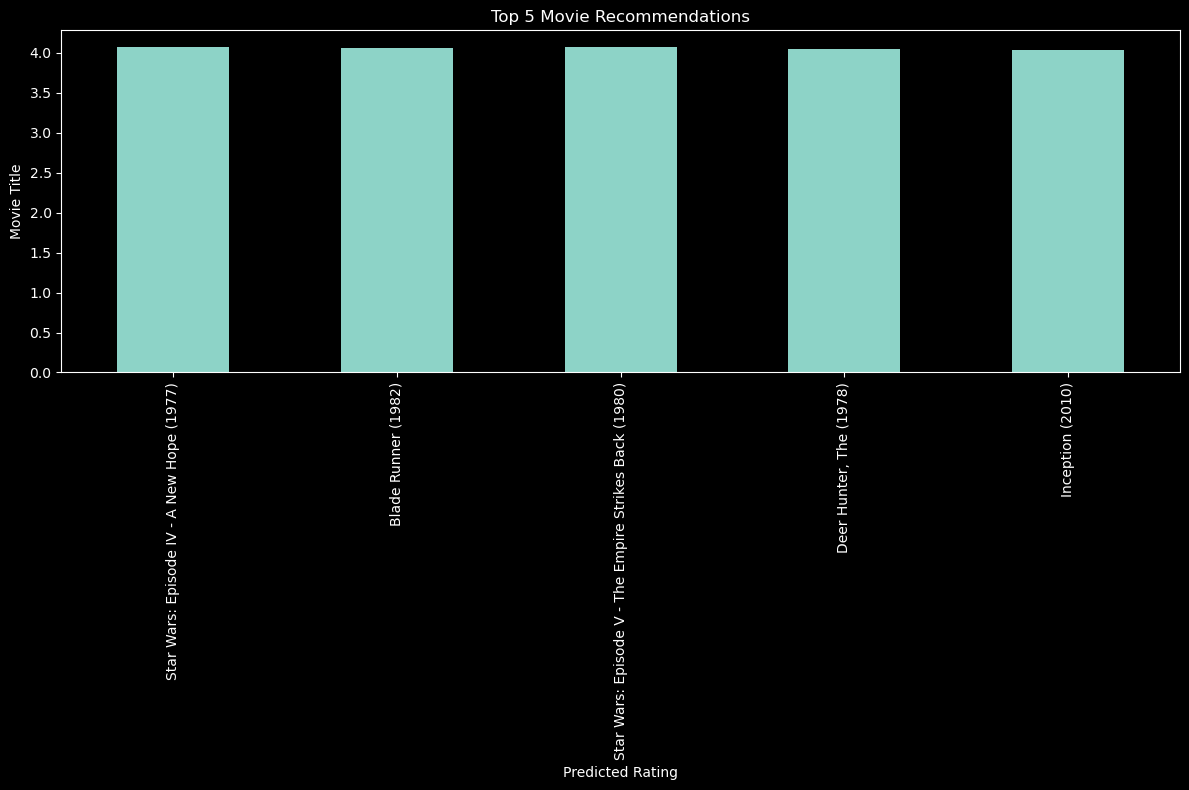

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 35970)
Traceback (most recent call last):
  File "/root/anaconda3/envs/pyspark/lib/python3.8/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/root/anaconda3/envs/pyspark/lib/python3.8/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/root/anaconda3/envs/pyspark/lib/python3.8/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/root/anaconda3/envs/pyspark/lib/python3.8/socketserver.py", line 747, in __init__
    self.handle()
  File "/root/anaconda3/envs/pyspark/lib/python3.8/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/root/anaconda3/envs/pyspark/lib/python3.8/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/root/anaconda

In [4]:
def train_evaluate_visualize(data_ready):
    """
    Train, evaluate, and visualize movie recommendations using a Random Forest model.

    Args:
    data_ready (DataFrame): DataFrame containing prepared features for training.
    """

    # Splitting the dataset
    training_features, test_features = data_ready.randomSplit([0.7, 0.3])

    # Training the Random Forest model
    rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="rating",
    numTrees=10,
    maxDepth=7,
    maxBins=32,
    minInstancesPerNode=1
    )   
    model = rf.fit(training_features)

    # Evaluate model on test dataset
    predictions_df = model.transform(test_features)
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

    # Calculate and output evaluation metrics
    rmse = rmse_evaluator.evaluate(predictions_df)
    mae = mae_evaluator.evaluate(predictions_df)
    print(f"Root Mean Square Error (RMSE): {rmse}")
    print(f"Mean Absolute Error (MAE): {mae}")

    #Calculate average predition rating of every movie
    avg_predictions_df = predictions_df.groupBy("movieId").avg("prediction")

    # Get top5 movie recommendations
    top_predictions = avg_predictions_df.orderBy('avg(prediction)', ascending=False).limit(5)

    # Join with the movies dataframe to get movie titles
    movies_df = spark.read.csv("dataset/movies.csv", header=True, inferSchema=True)  # Load movies data
    top_movies_with_titles = top_predictions.join(movies_df, 'movieId').select('title', 'avg(prediction)')
    print(top_movies_with_titles)

    # Convert to pandas dataframe for visualization
    top_movies_pd = top_movies_with_titles.toPandas()
    top_movies_pd.set_index('title', inplace=True)

    # Plot
    plt.figure(figsize=(12, 8))
    top_movies_pd['avg(prediction)'].plot(kind='bar')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Movie Title')
    plt.title('Top 5 Movie Recommendations')
    plt.tight_layout()
    plt.show()
    plt.close()


train_evaluate_visualize(data_ready)

# Part 5: Model Comparison

**ALS model**:
+ Advantages: It is suitable for large-scale data sets, can effectively handle sparsity problems, and is often used in recommendation systems.
+ Disadvantages: Need to adjust multiple parameters, sensitive to cold start issues.

**Random forest model**:
+ Advantages: It handles nonlinear relationships well and is less prone to overfitting.
+ Disadvantages: A large amount of feature engineering is required and the computational cost is high.